In [1]:
#import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
tf.compat.v1.disable_eager_execution()

In [2]:
#load the movie data
movies = pd.read_csv("ml-latest/movies.csv")
ratings = pd.read_csv("ml-latest/ratings.csv")

In [3]:
#modify the dataframes to remove unused columns
movies["list_index"] = movies.index
data = pd.merge(movies,ratings, on="movieId")
data = data.drop(["timestamp", "genres", "title"], 1)
data_grouped_user = data.groupby("userId")

In [4]:
#create training and test datasets
users = len(data_grouped_user)
X = []
for uid, curuser in data_grouped_user:
    temp = [0]*len(movies)
    for num, mov in curuser.iterrows():
        temp[int(mov["list_index"])] = mov['rating'] / 5.0
    X.append(temp)
    if users == 0:
        break
    users -= 1
split = int(len(X)*0.75)
train,test = X[:split],X[split:]

In [5]:
#build the RBM
hidden_units = 100
visible_units = len(movies)
visible = tf.compat.v1.placeholder("float", [visible_units])
hidden = tf.compat.v1.placeholder("float", [hidden_units])
w = tf.compat.v1.placeholder("float", [visible_units, hidden_units])
v0 = tf.compat.v1.placeholder("float", [None, visible_units])
sh0 = tf.nn.sigmoid(tf.matmul(v0, w) + hidden)
rh0 = tf.nn.relu(tf.sign(sh0 - tf.random.uniform(tf.shape(sh0))))
sv1 = tf.nn.sigmoid(tf.matmul(rh0, tf.transpose(w)) + visible)
rv1 = tf.nn.relu(tf.sign(sv1 - tf.random.uniform(tf.shape(sv1))))
h1 = tf.nn.sigmoid(tf.matmul(rv1, w) + hidden)

alpha = 0.9
pos = tf.matmul(tf.transpose(v0), rh0)
neg = tf.matmul(tf.transpose(rv1), h1)
div = pos - neg
div = div / tf.cast(tf.shape(v0)[0], "float")
u_w = w + alpha * div
u_vb = visible + alpha * tf.reduce_mean(v0 - rv1, 0)
u_hb = hidden + alpha * tf.reduce_mean(rh0 - h1, 0)
error = v0 - rv1
sum_error = tf.reduce_mean(error * error) #using mean squared error

cur_w = np.zeros([visible_units, hidden_units], np.float32)
cur_vb = np.zeros([visible_units], np.float32)
cur_hb = np.zeros([hidden_units], np.float32)
prv_w = np.zeros([visible_units, hidden_units], np.float32)
prv_vb = np.zeros([visible_units], np.float32)
prv_hb = np.zeros([hidden_units], np.float32)
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

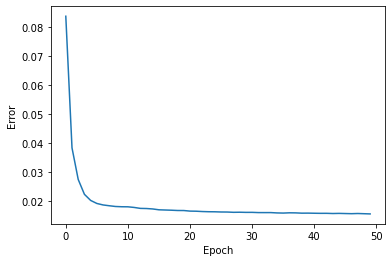

In [6]:
#train the RBM
e = 50 #number of epochs
b = 32 #batch size
errors = []
for i in range(e):
    for start,end in zip(range(0, len(train), b), range(b, len(train), b)):
        batch = train[start:end]
        cur_w = sess.run(u_w, feed_dict={v0:batch, w:prv_w, visible:prv_vb, hidden:prv_hb})
        cur_vb = sess.run(u_vb, feed_dict={v0:batch, w:prv_w, visible:prv_vb, hidden:prv_hb})
        cur_hb = sess.run(u_hb, feed_dict={v0:batch, w:prv_w, visible:prv_vb, hidden:prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(sum_error, feed_dict={v0:X, w:cur_w, visible:cur_vb, hidden:cur_hb}))
plt.plot(errors)
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.show()

In [7]:
def get_recommendation_manual(u, number=10):
    user = [test[u]]
    hh0 = tf.nn.sigmoid(tf.matmul(v0, w) + hidden)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(w)) + visible)
    feed = sess.run(hh0, feed_dict={v0:user, w:prv_w, hidden:prv_hb})
    rec = sess.run(vv1, feed_dict={hh0:feed, w:prv_w, visible:prv_vb})
    scored_movies = movies
    scored_movies["Recommendation Score"] = rec[0]
    return scored_movies.sort_values(["Recommendation Score"], ascending=False).head(number)

In [11]:
get_recommendation_manual(10)

,movieId,title,genres,list_index,Recommendation Score
176,208,Waterworld (1995),Action|Adventure|Sci-Fi,176,0.935959
337,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,337,0.927060
253,292,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,253,0.906693
97,110,Braveheart (1995),Action|Drama|War,97,0.871913
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,510,0.852316
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,277,0.811201
509,592,Batman (1989),Action|Crime|Thriller,509,0.791793
134,161,Crimson Tide (1995),Drama|Thriller|War,134,0.780923
307,349,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,307,0.773712
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,257,0.768993
